In [1]:
import sys 
import mariadb
import pandas as pd
from datetime import datetime

# 기본 플롯 설정

In [193]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

warnings.filterwarnings('ignore')

# pymysql로 연결

In [14]:
import yaml
with open('./config/config.yml') as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)['mysql']
    host=conf['host'] 
    user=conf['user'] 
    passwd=conf['passwd'] 
    port=conf['port']

In [15]:
# import the mysql client for python

import pymysql
			
database = "sample"
database=database
conn = pymysql.connect(host=host, 
                       user=user, 
                       password=passwd, 
                       database=database, 
                       port=port)

cur = conn.cursor()


## DB엔진 확인

In [16]:
cur = conn.cursor()
#query = f"INSERT INTO PRODUCT (PRODUCT_ID, price,PRODUCT_TYPE) VALUES ('{PRODUCT_ID}', '{price}', '{PRODUCT_TYPE}')"
q = '''
select engine, support 
from information_schema.engines
where support='DEFAULT'
'''

# default 엔진 수정
'''
SET default_storage_engine=엔진이름;
'''
cur.execute(q)
print(f"{cur.rowcount} details inserted")
conn.commit()
#conn.close()


1 details inserted


In [17]:
rst = cur.fetchall()
rst[0]

('InnoDB', 'DEFAULT')

# 테이블 컬럼 보기

In [36]:
q = 'SHOW COLUMNS FROM sample.superstore'
cur.execute(q)
rst = cur.fetchall()
conn.commit()
#conn.close()
#rst

# 엑셀 데이터 db에 넣기

In [41]:
# df = pd.read_excel('Sample - Superstore.xls', sheet_name=0)

In [42]:
#! pip3 install xlrd
#!pip install pymysql
#!pip install sqlalchemy

In [76]:
df = pd.read_csv('./data/action_log.csv')

# 데이터 DB에 넣기

In [29]:
from sqlalchemy import create_engine

db_connection_str = f'mysql+pymysql://{user}:{passwd}@{host}/{database}'
db_connection = create_engine(db_connection_str)
conn = db_connection.connect()

In [77]:
df.to_sql(name='action_log', 
          con=db_connection, 
          if_exists='replace', 
          index=False)

In [60]:
q = '''
with reg_month as (
    SELECT *, DATE_FORMAT(register_date,"%Y-%m") as new_reg_date, count(*) as new_users
    FROM mrt_users
    group by new_reg_date
)


select *
from reg_month as r
join (
    SELECT *, DATE_FORMAT(register_date,"%Y-%m") as new_reg_date, count(*) as new_users
    FROM action_log
    group by new_reg_date
) as act
#on r.reg_month = act.action_month

'''


'''
SELECT * , count(*) as count_
FROM mrt_users
group by register_date
'''


"""
RENAME TABLE mst_users TO mrt_users
"""

cur.execute(q)
print(f"{cur.rowcount} details inserted")
conn.commit()
#conn.close()

72 details inserted


In [61]:
rst = cur.fetchall()

# ListenBrainz 데이터 전처리
1. 데이터 날짜 다 들어갔는지 확인 (누락부분 채워넣기) 
2. tags 값 없으면 컬럼 삭제
3.  

## - 데이터 시간 검사
- 데이터 시간 순서가 섞여있음

In [126]:
# 큰 데이터 나눠가져오기
chunksize = 10**4
import glob, os

csv_files = glob.glob("../DE/listenBrainz_data_201501_to_201605/*.csv")
# "../DE/listenBrainz_data_201501_to_201605/bq-results-20220209-20150101-20150531.csv"
tags_basket = [] 
for f in csv_files:
    earliest_t = None
    last_t = None
    csv_chunk = pd.read_csv(f,chunksize=chunksize)

    num_lines = 0
    test_chunk = None
    tags_nan_check = 0

    for i, chunk in enumerate(csv_chunk) :
        chunk = chunk.set_index('listened_at')
        earliest_t = chunk.index.min() if not earliest_t else min(earliest_t, chunk.index.min())
        last_t = chunk.index.max() if not last_t else max(last_t, chunk.index.max())
        num_lines += chunksize 

        try:
            tags_nan_check += chunk.tags.isna().count() 
            tags_basket.extend(list(chunk[chunk.tags.notna()]['tags']))
            # 시간 체크
            #piece = chunk.loc['2015-01-01 13:17':'2015-01-01 13:18']
            #if piece.shape[0] >0:
            #    pass
                #print(f"{i}th : ")
                #print(piece)

        except Exception as e:
            print(e)
        if i ==0:
            test_chunk = chunk

    print(f'file_name: {os.path.basename(f)}')
    print(f'- from {earliest_t} to {last_t}')
    print(f'- # of lines : {num_lines}')
    print(f'- # of NaN in tags : {tags_nan_check} ({round(tags_nan_check*100/num_lines, 2)}%)') 
    print()

file_name: bq-results-20220209-20150101-20150531.csv
# from 2015-01-01 00:00:06 UTC to 2015-05-31 23:59:51 UTC
# of lines : 6010000
# of NaN in tags : 6006601 (99.94%)

file_name: bq-results-20220209-20150601-20150931.csv
# from 2015-06-01 00:00:01 UTC to 2015-09-13 21:01:09 UTC
# of lines : 570000
# of NaN in tags : 569850 (99.97%)

file_name: bq-results-20220209-20151001-20160131.csv
# from 2015-10-01 00:00:04 UTC to 2016-01-31 23:59:57 UTC
# of lines : 4930000
# of NaN in tags : 4927275 (99.94%)

file_name: bq-results-20220209-20160201_20160531.csv
# from 2016-02-01 00:00:00 UTC to 2016-05-31 23:59:57 UTC
# of lines : 5060000
# of NaN in tags : 5053092 (99.86%)

file_name: bq-results-20220209-20160601_20160930.csv
# from 2016-06-01 00:00:04 UTC to 2016-09-30 23:59:59 UTC
# of lines : 5070000
# of NaN in tags : 5065032 (99.9%)

file_name: bq-results-20220209-20161001_20170101.csv
# from 2016-10-01 00:00:01 UTC to 2017-01-01 23:59:58 UTC
# of lines : 4210000
# of NaN in tags : 4204495

tag 버리기 전에 뭐가 들어가 있나 확인.
- 음악 장르가 들어가 있음

In [128]:
len(tags_basket)
tags = pd.Series(tags_basket)
tags.drop_duplicates()

0                                              test1,test2
1                             Rock And Roll,Merseybeat,Pop
24                            Rock And Roll,Pop,Beat Music
38                                           Rock And Roll
42                                                    Beat
                               ...                        
20522                                  Downtempo,Synth-pop
20545    Indie,Female Vocalists,Pop,French,Singer-Songw...
20555    Electronica,Experimental,Electro,Minimal,Indus...
20794                                            Dream pop
20873                                              PopSike
Length: 772, dtype: object

## - 초/분/시간 당 로그양 살펴보기
- 여러 번 샘플링해서 통계를 내야 하지만 먼저 특정 하루만 살펴보자

관찰:
- release_name과 release_msid를 전처리해줘야 함.

In [219]:
f_ =  "../DE/listenBrainz_data_201501_to_201605/bq-results-20220209-20170901_20171231.csv"
csv_chunk = pd.read_csv(f_, chunksize=chunksize)

num_lines = 0
test_chunk = None
tags_nan_check = 0
sample_df = pd.DataFrame()
sample_t = '2017-09-01'
for i, chunk in enumerate(csv_chunk) :
    chunk = chunk.set_index('listened_at')
    num_lines += chunksize 

    try:
        tags_nan_check += chunk.tags.isna().count() 
        tags_basket.extend(list(chunk[chunk.tags.notna()]['tags']))
        # 시간 체크
        sample_df = pd.concat([sample_df, chunk.loc[sample_t:sample_t+' 23:59:59']])
        #if piece.shape[0] >0:
        #    pass
            #print(f"{i}th : ")
            #print(piece)

    except Exception as e:
        pass
        #print(e)
    if i ==0:
        test_chunk = chunk

print(f'file_name: {os.path.basename(f)}')
print(f'- # of logs at {sample_t} : {sample_df.shape[0]}')

print()

file_name: bq-results-20220209-20170901_20171231.csv
- # of logs at 2017-09-01 : 42260



head와 tail을 살펴 값이 시간 확인

In [220]:
sample_df.head()

,user_name,artist_name,artist_msid,release_name,release_msid,track_name,recording_msid,tags
listened_at,,,,,,,,
2017-09-01 00:00:06 UTC,braydenmclellan,Small Black,3e1256e3-4183-4dc5-bf90-ad1c9b0c8eb3,NaN,NaN,Search Party,56177420-d17d-47dd-83d9-9bcde19cbb5d,NaN
2017-09-01 00:00:09 UTC,user18081971,Slowdive,f69942be-bccd-44eb-8962-2e5025507196,Souvlaki,f8a36f48-65d3-4369-9c2d-f641f17f458b,Souvlaki Space Station,69ea7fb7-6df8-403c-8748-fcb0827d1fb4,NaN
2017-09-01 00:00:10 UTC,zimonledemon,The Kinks,b76996af-1dce-4fa7-839a-42f2b781dfa2,NaN,9fb96da2-519a-49bc-8240-434e9118add5,Waterloo Sunset - Mono Version,425a1718-5186-4c4e-a5c5-8f78479db6fa,NaN
2017-09-01 00:00:17 UTC,whygottalogin,Pop Will Eat Itself,edd660e7-70a5-4385-ac87-1a773b806891,NaN,8c4a6d2d-b215-4d1a-831a-9feefc1e94e0,Poison To The Mind,9cef0949-f02a-4bfe-b4f4-ce12910a7853,NaN
2017-09-01 00:00:18 UTC,I_am_walking,A Victim Of Society,618341c5-6ef6-43e8-89a6-a2b0d6865f4b,NaN,NaN,The Revolution Will Not Be Televised (Gil Scot...,173ff0a9-25d9-449c-8646-6070305acf81,NaN


In [221]:
sample_df.tail()

,user_name,artist_name,artist_msid,release_name,release_msid,track_name,recording_msid,tags
listened_at,,,,,,,,
2017-09-01 23:59:46 UTC,SURIV,Jean Sébastien Bach / Wilhelm Kempff,94fd5409-7cd7-4553-a9b5-d6e248bcf60b,NaN,NaN,Choral-Prélude “Es ist gewisslich an der Zeit”...,ddfe562f-f00f-4899-974b-c45dc5906e6c,NaN
2017-09-01 23:59:51 UTC,yurrriq,Cakes Da Killa,12e115d8-709f-4f9b-93e1-c9988e35cf67,Shots Fired X Thirst Trap,a8a4a7b1-518a-415d-9983-8aa6dc0d893b,Thirst Trap,0b684cab-f396-47fb-8d3c-d74be03630ee,NaN
2017-09-01 23:59:52 UTC,davidsuxx,Chara,c23397b8-380a-4a38-bd64-af9587b262d2,NaN,278cfa80-0b61-473f-a1be-e0d7003542e6,元気をだして,50011add-24d9-4ebc-bc53-4295cd5d5f70,NaN
2017-09-01 23:59:56 UTC,phonebox,Jesu / Sun Kil Moon,ee937d9c-27a0-49b4-8525-cafdf6cc596c,30 Seconds To The Decline Of Planet Earth,4d26fa39-7ad8-427d-a806-957000f3568c,Wheat Bread,4bd081a5-23f0-4de6-9412-75938a2347d2,NaN
2017-09-01 23:59:57 UTC,knockergrowl,System of a Down,9e5f26f1-95ab-43ad-b7f9-22ff5cd29dee,NaN,eec8e83b-6f76-4e88-bdbd-f810d73a1f20,Jet Pilot,edb8ce70-3bcb-4997-a32b-def780f070fb,NaN


release_name과 release_msid를 전처리해줘야 함.

In [222]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42260 entries, 2017-09-01 00:00:06 UTC to 2017-09-01 23:59:57 UTC
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_name       42260 non-null  object
 1   artist_name     42260 non-null  object
 2   artist_msid     42260 non-null  object
 3   release_name    14376 non-null  object
 4   release_msid    40638 non-null  object
 5   track_name      42260 non-null  object
 6   recording_msid  42260 non-null  object
 7   tags            120 non-null    object
dtypes: object(8)
memory usage: 2.9+ MB


<br>
하루의 초/분/시간당 로그유입수 통계를 보자

In [227]:
sample_df = sample_df.reset_index('listened_at')
times = pd.to_datetime(sample_df.listened_at)

#초당 로그 통계
sample_df.groupby([times.dt.hour, times.dt.minute, times.dt.second])[['listened_at']].count().describe()

,listened_at
count,32757.000000
mean,1.290106
std,0.576436
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,12.000000


In [228]:
# 분당 로그 통계
sample_df.groupby([times.dt.hour, times.dt.minute])[['listened_at']].count().describe()

,listened_at
count,1440.000000
mean,29.347222
std,9.157657
min,8.000000
25%,22.000000
50%,30.000000
75%,36.000000
max,57.000000


In [229]:
# 시간당 로그 통계
sample_df.groupby([times.dt.hour])[['listened_at']].count().describe()

,listened_at
count,24.000000
mean,1760.833333
std,464.896498
min,1037.000000
25%,1302.250000
50%,1823.500000
75%,2149.500000
max,2376.000000


위의 표를 시각화해볼까? <br>
타이틀하고 x,y축 label을 잘 달아줘야 하는데.

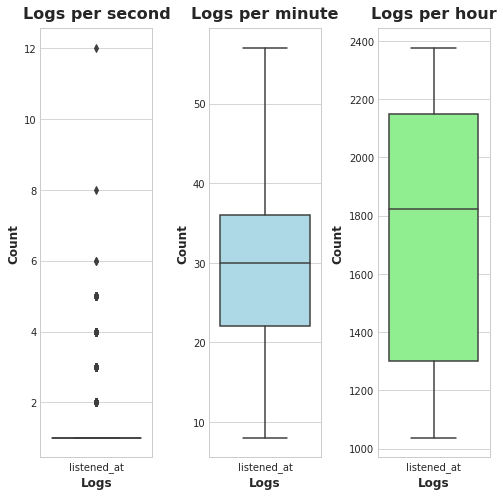

In [245]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 7))

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
partitions = [[times.dt.hour, times.dt.minute, times.dt.second], 
               [times.dt.hour, times.dt.minute], 
               [times.dt.hour]]

for i, (part, color) in enumerate(zip(partitions, colors)):
    count_logs_h = sample_df.groupby(part)[['listened_at']].count()
    bplot = sns.boxplot(data=count_logs_h, 
                        notch=False,
                        ax=axes[i])

    bplot.set_title('Notched box plot')
    
    # adding transparency to colors
    for patch in bplot.artists:
        patch.set_facecolor(color)

# adding horizontal grid lines
titles = ['Logs per second','Logs per minute','Logs per hour']
for ax,t in zip(axes, titles):
    ax.set_title(t)
    ax.yaxis.grid(True)
    ax.set_xlabel('Logs')
    ax.set_ylabel('Count')

histplot으로는 어떠려나.

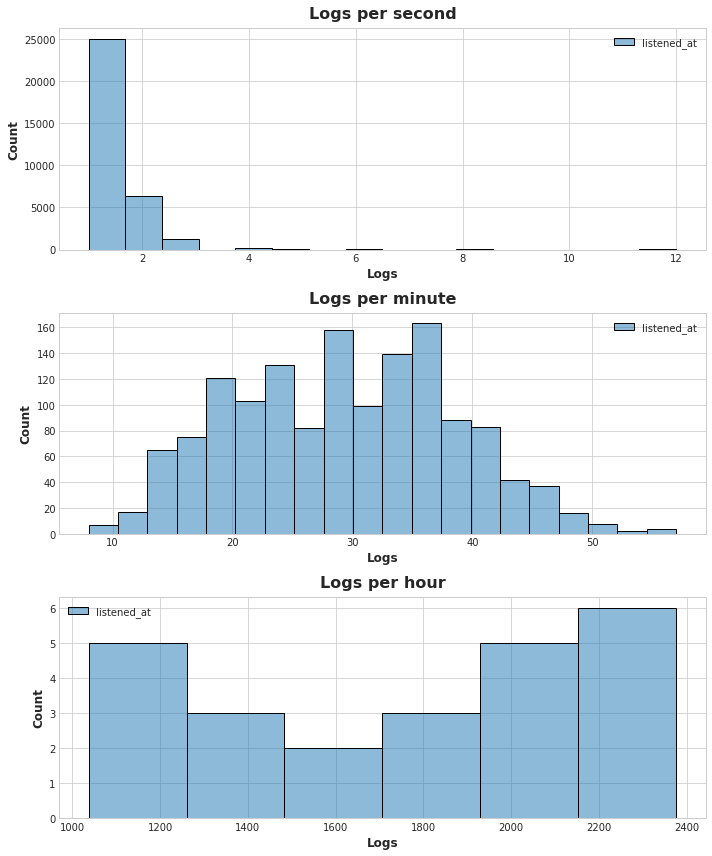

In [231]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
partitions = [[times.dt.hour, times.dt.minute, times.dt.second], 
               [times.dt.hour, times.dt.minute], 
               [times.dt.hour]]
for i, (part, color) in enumerate(zip(partitions, colors)):
    count_logs_h = sample_df.groupby(part)[['listened_at']].count()
    bplot = sns.histplot(data=count_logs_h, 
                        ax=axes[i])
    
    # adding transparency to colors
    for patch in bplot.artists:
        patch.set_facecolor(color)

# adding horizontal grid lines
titles = ['second','minute','hour']
for ax, t in zip(axes, titles):
    ax.set_title(f'Logs per {t}')
    ax.yaxis.grid(True)
    ax.set_xlabel(f'Logs')
    ax.set_ylabel('Count')

##  - 타임라인으로 본 로그양의 변화
- 하루 주기가 있는지 궁금하다. 다른 데이터를 봐야 한다

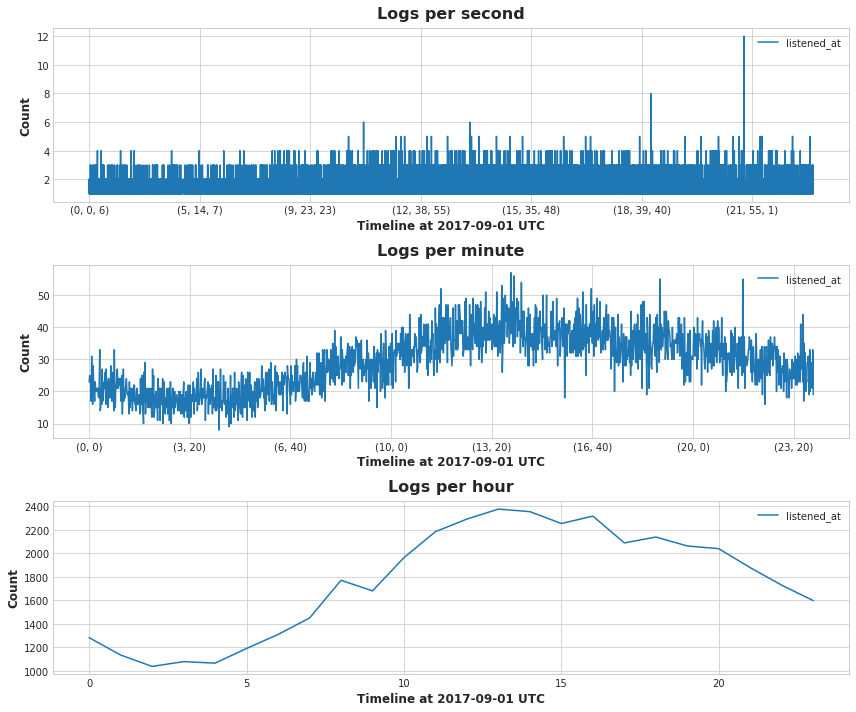

In [243]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
partitions = [[times.dt.hour, times.dt.minute, times.dt.second], 
               [times.dt.hour, times.dt.minute], 
               [times.dt.hour]]

for i, (part, color) in enumerate(zip(partitions, colors)):
    count_logs_h = sample_df.groupby(part)[['listened_at']].count().plot(ax=axes[i])

# adding horizontal grid lines
titles = ['Logs per second','Logs per minute','Logs per hour']
for ax,t in zip(axes, titles):
    ax.set_title(t)
    ax.yaxis.grid(True)
    ax.set_xlabel(f'Timeline at {sample_t} UTC')
    ax.set_ylabel('Count')

# 멀티프로세스

In [ ]:
import multiprocessing as mp

def parallel_dataframe(df, func):
    global num_cores
    df_split = np.array_split(df, num_cores)
    pool = mp.Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [4]:
! cd /data/airflow/dags && ls -l

total 8
drwxrwxrwx 1 root root    0 Feb  6 07:45 docker_job
drwxrwxrwx 1 root root    0 Feb 10 08:02 elt_pipeline
drwxrwxrwx 1 root root 4096 Feb  6 07:45 __pycache__
drwxrwxrwx 1 root root 4096 Feb 10 08:02 test


# 테이블 생성

In [ ]:
q = '''
CREATE TABLE user(
    id varchar(32) not null,
    name varchar(32) not null,
    primary key(id)
)ENGINE=INNODB CHARSET=utf8;
'''
cur.execute(q)
rst = cur.fetchall()
conn.commit()
#conn.close()
